# Model Explicit Likelihood Inference
Infer from a cosmological model via MCMC samplers. 

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.2' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

import mlflow
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

2024-05-04 14:09:29.809615: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [27]:
!jupyter nbconvert --to script ./src/montecosmo/tests/model_ELI.ipynb

/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[NbConvertApp] Converting notebook ./src/montecosmo/tests/model_ELI.ipynb to script
[NbConvertApp] Writing 15651 bytes to src/montecosmo/tests/model_ELI.py


## Inference

### Import

In [2]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn
from montecosmo.models import print_config, get_prior_mean, default_config as config

# Build and render model
# config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int))
model = partial(pmrsd_model, **config)
print_config(model)

# Get fiducial parameters
param_fn = get_param_fn(**config)
fiduc_model = condition(partial(model, trace_reparam=True), param_fn(inverse=True, **get_prior_mean(model)))
fiduc_params = get_simulator(fiduc_model)(rng_seed=0)

# # Chain init
@jit
@vmap
def sample_init_chains(rng_key, scale_std):
    params_ = seed(prior_model, rng_key)(**config)
    init_params = get_param_fn(scale_std=scale_std, **config)(**params_)
    return get_param_fn(**config)(inverse=True, **init_params)

init_params_ = sample_init_chains(jr.split(jr.key(1), 7), jnp.array([0]+6*[1/10]))
init_params_ = tree_map(lambda x,y: jnp.concatenate((jnp.array(x)[None], y), axis=0), 
                        get_param_fn(**config)(inverse=True, **fiduc_params), init_params_)
# pickle_dump(fiduc_params, save_dir+"fiduc_params2.p")
# pickle_dump(init_params_, save_dir+"init_params_2.p")

# Load fiducial and chain init params
# fiduc_params = pickle_load(save_dir+"fiduc_params.p")
# init_params_ = pickle_load(save_dir+"init_params_.p")

# Condition model on observables
obs_names = ['obs_mesh']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_model = condition(model, obs_params)
logp_fn = get_logp_fn(obs_model)
# print(fiduc_params, init_params_)

# CONFIG
{'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_m': ['{\\Omega}_m', 0.3111, 0.2], 'sigma8': ['{\\sigma}_8', 0.8102, 0.2], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 2.0], 'bs2': ['{b}_{s^2}', 0.0, 2.0], 'bn2': ['{b}_{\\nabla^2}', 0.0, 2.0]}, 'lik_config': {'obs_std': 1.0}}

# INFOS
cell_size:        [10.0, 10.0, 10.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.31416 h/Mpc
mean_gxy_density: 1.000 gxy/cell



/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

In [3]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [ 0.         -0.          0.12401016 -0.0990268   0.13384302 -0.14487448
  0.04103637  0.01980024] 
 [ 0.9133829   0.          0.0867136   0.09719937  0.2301314  -0.13022844
 -0.06570472  0.16659732]


In [13]:
print(fiduc_params.keys(), '\n', init_params_['Omega_m_'], '\n', init_params_['init_mesh_'][:,0,0,0])

dict_keys(['Omega_m_', 'sigma8_', 'b1_', 'b2_', 'bs2_', 'bn2_', 'init_mesh_', 'Omega_m', 'sigma8', 'init_mesh', 'b1', 'b2', 'bs2', 'bn2', 'obs_mesh']) 
 [-0.0796027  -0.07960285  0.04843828 -0.21266134  0.05903318 -0.31464675
 -0.04204855 -0.06571629] 
 [ 0.913383    0.          0.0867136   0.09719938  0.23013133 -0.13022844
 -0.06570464  0.16659732]


### Run

In [4]:
# num_samples, max_tree_depth, n_runs, num_chains = 256, 10, 4, 8
# num_samples, max_tree_depth, n_runs, num_chains = 64, 10, 4, 1
num_samples, max_tree_depth, n_runs, num_chains = 64, 10, 4, 8

# Variables to save
extra_fields = ['num_steps'] # e.g. 'num_steps'
# save_path = save_dir + f"NUTS_ns{num_samples:d}_x_nc{num_chains}"
save_path = save_dir + f"NUTS_ns{num_samples:d}_test7"
# save_path = save_dir + f"NUTS_ns{num_samples:d}"

nuts_kernel = numpyro.infer.NUTS(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params)
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=True,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # XXX: dense matrix for cosmo params joint, diagonal for the rest
    step_size=1e-3, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,)

hmc_kernel = numpyro.infer.HMC(
    model=obs_model,
    # init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    # adapt_mass_matrix=False,
    step_size=1e-40, 
    # adapt_step_size=False,
    # num_steps=1,
    # trajectory_length=, # (2**max_tree_depth-1)*step_size_NUTS/4, compare with default 2pi
    )

# # Propose MALA step size based on [Chen+2019](http://arxiv.org/abs/1801.02309)
# L_smoothness, m_strong_convex = 1, 1 # log density regularity properties
# condition_number = L_smoothness / m_strong_convex
# print(f"MALA step size proposal={1 / (L_smoothness * (config['mesh_size'].prod() * condition_number)**0.5):e}")

# from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA
# mala_kernel = MALA(model=obs_model,
#                     init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
#                     step_size=0.001,)

mcmc = numpyro.infer.MCMC(
    sampler=nuts_kernel,
    num_warmup=num_samples,
    num_samples=num_samples, # for each run
    num_chains=num_chains,
    chain_method="vectorized",
    progress_bar=True,)

# last_state = pickle_load(save_dir+"NUTS_ns60_mtd10_laststate16.p")
# mcmc.post_warmup_state = last_state

In [46]:
# mlflow.end_run()
# mlflow.start_run(run_name="NUTS, 1 vs. 1/10 init cond")
# mlflow.log_params(config)
# mlflow.log_params({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})

In [5]:
init_params_one_ = tree_map(lambda x: x[1], init_params_)
# mlflow.log_metric('halt',0) # 31.46s/it 4chains, 37.59s/it 8chains
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_one_)
# mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields, init_params=init_params_)
# mlflow.log_metric('halt',1)

run 0/4 (warmup)


/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest/lib/python3.12/site-p

KeyboardInterrupt: 

In [ ]:
mclmc = blackjax.mcmc.mclmc.mclmc(
    logdensity_fn=logdensity_fn,
    L=L,
    step_size=step_size
)
state = mclmc.init(position)
new_state, info = mclmc.step(rng_key, state)

## Analysis

In [6]:
# temp = pickle_load(save_dir+'NUTS_mtd10_2.p')
# print(temp.keys())
# temp['bs2_'] = temp['bs_']
# temp['bn2_'] = temp['bnl_']
# temp.pop('bs_')
# temp.pop('bnl_')
# print(temp.keys())
# # pickle_dump(temp, save_dir+'NUTS_mtd10_2.p')

In [12]:
start_run, end_run = 0,1
var_names = [name+'_' for name in config['prior_config']] + ['num_steps']
# var_names = None

# post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1,0], verbose=True)
post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1], verbose=True)
# mlflow.log_params({'n_samples':n_samples, 'n_evals':n_evals})
# post_samples = [param_vfn(**s) for s in post_samples_]
post_samples = get_param_fn(**config)(**post_samples_)

loading: NUTS_ns64_test7
total n_samples: (8, 128), total n_evals: [128405 130176  94874 128058 126994 129161 125605 129924]


In [8]:
# post_samples2 = {name[:-1]: post_samples_[name] for name in post_samples_}
# post_samples2.pop('num_step');

### Chain

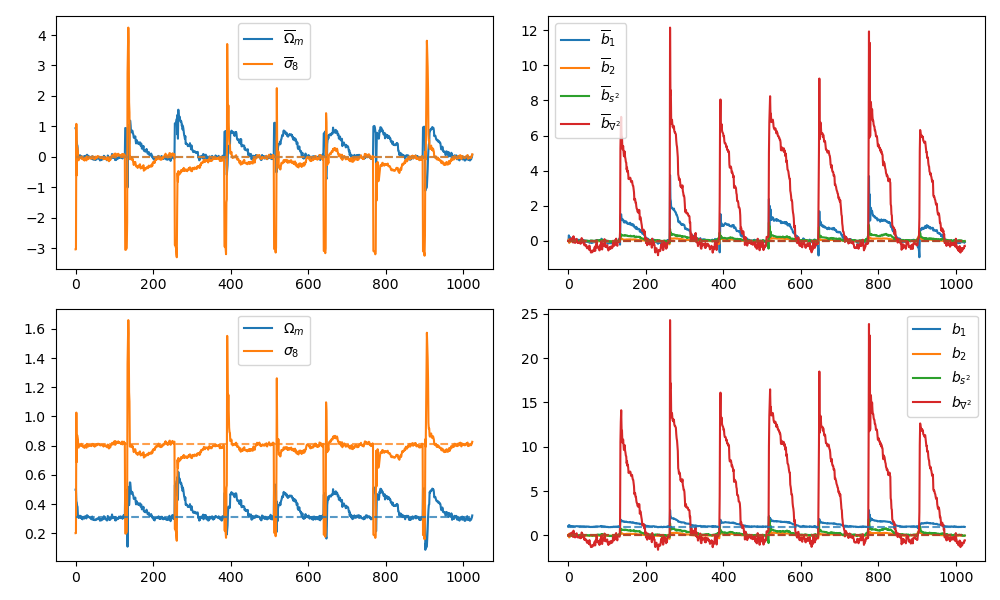

In [20]:
%matplotlib widget
def plot_chain(samples:dict, prior_config:dict, fiduc:dict, **config):
    labels = []
    for name in samples:
        if name.endswith('_'): # convention for a latent value 
            lab = "\\overline"+prior_config[name[:-1]][0]
        else:
            lab = prior_config[name][0]
        labels.append('$'+lab+'$')

    samples_arr = np.array(list((samples.values()))).T

    plt.plot(samples_arr, label=labels)
    plt.hlines([fiduc[name] for name in samples], 
            xmin=0, xmax=len(samples_arr), 
            ls="--", alpha=0.75,
            color=[f"C{i}" for i in range(len(samples))],)
# slice_toplot = np.concatenate([range(i,i+10) for i in [0,5*60-5, 6*60-5]])

plot_fn = partial(plot_chain, fiduc=fiduc_params, **config)
plt.figure(figsize=(10,6))
plt.subplot(221)
plot_fn({name:post_samples_[name] for name in ['Omega_m_','sigma8_']})
plt.legend(), 
plt.subplot(222)
plot_fn({name:post_samples_[name] for name in ['b1_','b2_','bs2_','bn2_']})
plt.legend(), 
plt.subplot(223)
plot_fn({name:post_samples[name] for name in ['Omega_m','sigma8']})
plt.legend(), 
plt.subplot(224)
plot_fn({name:post_samples[name] for name in ['b1', 'b2','bs2','bn2']})
plt.legend(), 
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"NUTS_1o1_chain.svg")
plt.show();

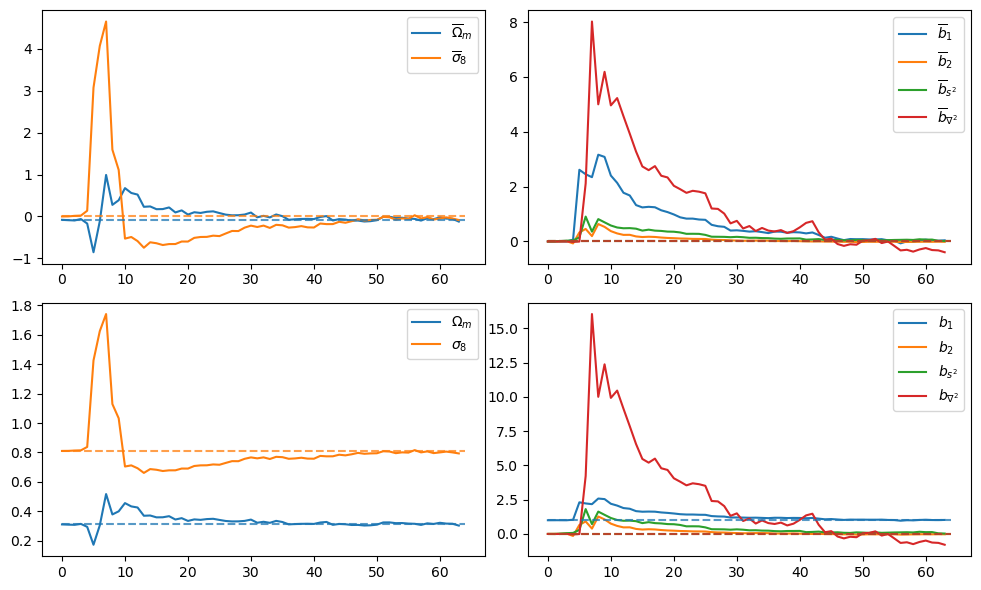

In [ ]:
%matplotlib inline
def plot_chain(samples:dict, prior_config:dict, fiduc:dict, **config):
    labels = []
    for name in samples:
        if name.endswith('_'): # convention for a latent value 
            lab = "\\overline"+prior_config[name[:-1]][0]
        else:
            lab = prior_config[name][0]
        labels.append('$'+lab+'$')

    samples_arr = np.array(list((samples.values()))).T

    plt.plot(samples_arr, label=labels)
    plt.hlines([fiduc[name] for name in samples], 
            xmin=0, xmax=len(samples_arr), 
            ls="--", alpha=0.75,
            color=[f"C{i}" for i in range(len(samples))],)
# slice_toplot = np.concatenate([range(i,i+10) for i in [0,5*60-5, 6*60-5]])

plot_fn = partial(plot_chain, fiduc=fiduc_params, **config)
plt.figure(figsize=(10,6))
plt.subplot(221)
plot_fn({name:post_samples_[name] for name in ['Omega_m_','sigma8_']})
plt.legend(), 
plt.subplot(222)
plot_fn({name:post_samples_[name] for name in ['b1_','b2_','bs2_','bn2_']})
plt.legend(), 
plt.subplot(223)
plot_fn({name:post_samples[name] for name in ['Omega_m','sigma8']})
plt.legend(), 
plt.subplot(224)
plot_fn({name:post_samples[name] for name in ['b1', 'b2','bs2','bn2']})
plt.legend(), 
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"NUTS_1o1_chain.svg")
plt.show();

### Contours

In [101]:
np.broadcast_to(names, shape=(8,6)).tolist()

[['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2'],
 ['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2'],
 ['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2'],
 ['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2'],
 ['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2'],
 ['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2'],
 ['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2'],
 ['Omega_m', 'sigma8', 'b1', 'b2', 'bs2', 'bn2']]

In [81]:
np.moveaxis(list(samples.values()), 0, 1).shape

(8, 6, 128)

In [86]:
np.moveaxis(list(samples.values()), 0, 1).tolist()

[[[0.49956050515174866,
   0.4995737671852112,
   0.41993188858032227,
   0.412536084651947,
   0.38946735858917236,
   0.38226133584976196,
   0.32626476883888245,
   0.3127710819244385,
   0.30580151081085205,
   0.3158028721809387,
   0.3169432282447815,
   0.3212639391422272,
   0.32017359137535095,
   0.30496928095817566,
   0.31568315625190735,
   0.3159516155719757,
   0.30134090781211853,
   0.302413672208786,
   0.29631495475769043,
   0.312101811170578,
   0.3066209852695465,
   0.3068466782569885,
   0.3143408000469208,
   0.3018783628940582,
   0.31328529119491577,
   0.31709858775138855,
   0.31210851669311523,
   0.3121150732040405,
   0.3024688959121704,
   0.3238639235496521,
   0.32414567470550537,
   0.3161599338054657,
   0.3171337842941284,
   0.31402388215065,
   0.31100940704345703,
   0.3127433657646179,
   0.3109625577926636,
   0.3091731369495392,
   0.30427148938179016,
   0.30541497468948364,
   0.3005463480949402,
   0.2966650426387787,
   0.3110060095787048

In [13]:
np.moveaxis(samples_arr, 0, 2).shape

AxisError: destination: axis 2 is out of bounds for array of dimension 2

In [13]:
np.array(samples_arr).shape

(6, 1024)

In [78]:
names_arr = np.broadcast_to(names, shape=(8,6))
aaa = MCSamples(samples=[samples_arr[0], samples_arr[1]], names=names, files_are_chains=False)
aaa.getGelmanRubin()

Removed no burn in


TypeError: 'NoneType' object is not subscriptable

In [143]:
from getdist import MCSamples
samples_arr = list(post_samples.values())
samples_arr = np.moveaxis(samples_arr, 0, -1)
print(samples_arr.shape)
names = list(post_samples.keys())
gdsamples = MCSamples('hey', samples=samples_arr, weights=np.ones_like(samples_arr[...,0]))
# gdsamples = MCSamples(samples=[samples_arr[0], samples_arr[1]], weights=[np.ones_like(samples_arr)[0], np.ones_like(samples_arr)[1]])
print({name: gdsamples.getEffectiveSamples(i) for i, name in enumerate(names)})

# names = np.broadcast_to(names, shape=(8,6)).tolist()
# samples_arr = np.moveaxis(list(samples.values()), 0, 1)

# gdsamples_arr = [MCSamples(samples=samples_arr[0], names=names) for i in range(len(samples_arr))]
# print({name: gdsamples_arr[0].getGelmanRubin(i, gdsamples_arr) for i, name in enumerate(names)})

(8, 128, 6)
Removed no burn in
{'Omega_m': 40.848247845987906, 'sigma8': 209.05390046385392, 'b1': 33.339120979251675, 'b2': 37.35954933538124, 'bs2': 36.95352883478679, 'bn2': 31.883686999639238}


In [144]:
gdsamples.getSeparateChains()

TypeError: 'NoneType' object is not subscriptable

In [152]:
aaa = MCSamples(samples=samples_arr, weights=np.ones_like(samples_arr[...,0]))
aaa.loadChains('hey', files_or_samples=samples_arr, weights=np.ones_like(samples_arr[...,0]))
aaa.getSeparateChains()
aaa.getGelmanRubin(10, aaa.getSeparateChains())

Removed no burn in


AttributeError: 'NoneType' object has no attribute 'dot'

In [ ]:
paths = ["NUTS_ns4429_mtd3","NUTS_ns243_mtd8","NUTS_ns60_mtd10","NUTS_ns15_mtd12"]
legend_labels = ["NUTS, mtd=3", "NUTS, mtd=8","NUTS, mtd=10","NUTS, mtd=12"]
start_run, end_run = [1,1,1,1], [10,5,5,5]

load_paths = np.array([os.path.join(save_dir, path) for path in paths])
var_names = [name+'_' for name in config['prior_config']]

post_samples_ = load_runs(load_paths, start_run, end_run, var_names, verbose=True)
post_samples = [param_fn(**s) for s in post_samples_]

loading: NUTS_ns4429_mtd3
total run length: 44290
loading: NUTS_ns243_mtd8
total run length: 1215
loading: NUTS_ns60_mtd10
total run length: 300
loading: NUTS_ns15_mtd12
total run length: 75


In [29]:
from numpyro.diagnostics import print_summary
print_summary(post_samples, group_by_chain=True) # NOTE: group_by_chain if several chains


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.36      0.07      0.32      0.29      0.48     28.50      1.49
    sigma8      0.77      0.15      0.79      0.71      0.86    199.83      1.04
        b1      1.20      0.27      1.06      0.94      1.60     24.16      1.63
        b2      0.07      0.13      0.01     -0.05      0.27     27.55      1.49
       bs2      0.23      0.26      0.13     -0.06      0.63     24.64      1.54
       bn2      3.29      4.99      0.16     -1.33     11.50     23.43      1.75



<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2727240/2031991162.py:4: SyntaxWarning: invalid escape sequence '\s'
  gd1 = gdsamples.copy(label="NUTS, mtd=10, 1$\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})


Removed no burn in
# NUTS, mtd=10
using 4096 rows, 6 parameters; mean weight 1.0, tot weight 4096.0
Equiv number of single samples (sum w)/max(w): 4096
Effective number of weighted samples (sum w)^2/sum(w^2): 4096


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.39      0.21      0.32      0.04      0.75     34.05      1.03
        b1      0.65      1.27      1.00     -2.68      1.47     11.97      1.10
        b2     -1.50      4.91     -0.06     -3.76      1.43     15.39      1.08
       bn2      1.80      8.03     -0.90     -5.64     17.06     23.77      1.05
       bs2     -0.21      1.71      0.05     -3.01      1.30     44.67      1.03
    sigma8     -0.38      0.96     -0.27     -1.36      0.83     13.23      1.01



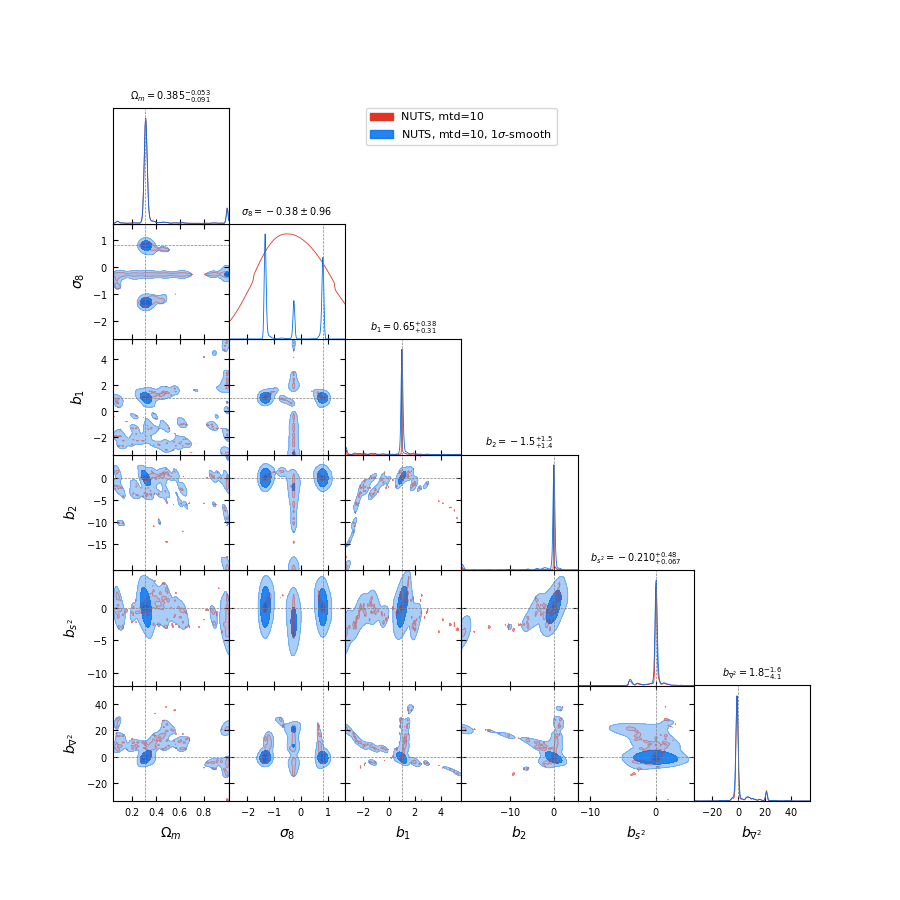

In [16]:
from montecosmo.utils import get_gdsamples, get_gdprior

gdsamples = get_gdsamples(post_samples, label="NUTS, mtd=10", verbose=True, **config)
gd1 = gdsamples.copy(label="NUTS, mtd=10, 1$\sigma$-smooth", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})

# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))
g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r's
g.triangle_plot(roots=[gdsamples, gd1] , 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
# plt.savefig('NUTS_mtd10_8192_unstandard_short.svg', bbox_inches='tight')
plt.show();

Removed no burn in
Removed no burn in
Removed no burn in


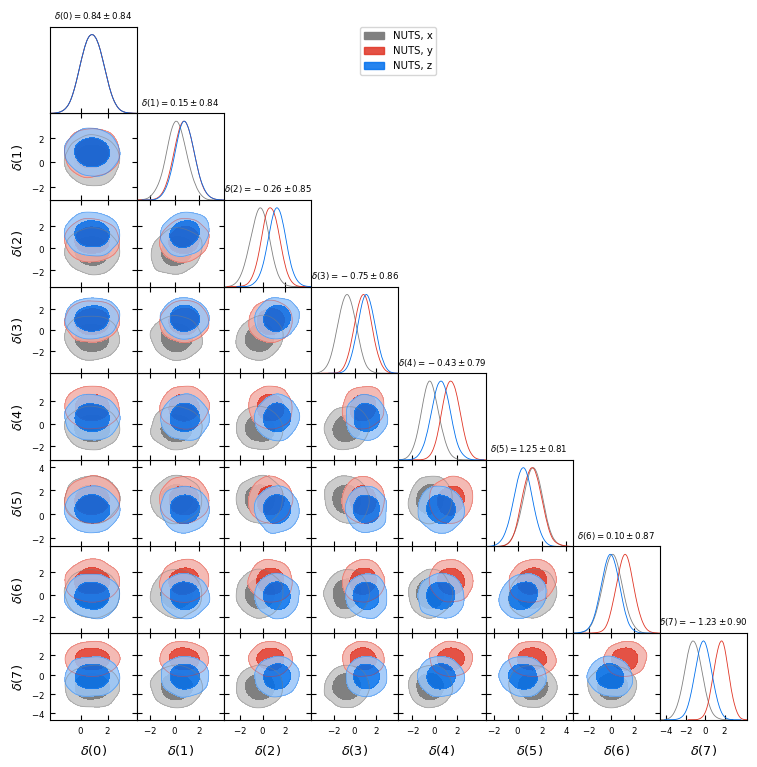

In [8]:
from getdist import MCSamples

def get_gdsamples_mesh(samples:dict, fiduc:dict, n:int, stop:int=None, axis:int=0, label:str=None):
    mesh_samples = samples['init_mesh']
    mesh_fiduc = fiduc['init_mesh']

    subsamples = {}
    subfiduc = {}
    labels = []
    slices0 = len(mesh_fiduc.shape)*[slice(0,1)]
    name0 = len(mesh_fiduc.shape) * ["0"]
    if stop is None:
        stop = mesh_fiduc.shape[axis]
    for i in np.linspace(0, stop, n, endpoint=False, dtype=int):
        slices, name = slices0.copy(), name0.copy()
        slices[axis] = slice(i,i+1)
        # name[axis] = str(i)
        # name = "delta("+",".join(name)+")"
        # lab = "\\"+name
        name = f"delta({i})"
        lab = "\\"+name

        subsamples[name] = mesh_samples[:,*slices].squeeze()
        subfiduc[name] = mesh_fiduc[*slices].squeeze()
        labels.append(lab)
 
    gdsamples = MCSamples(samples=list(subsamples.values()), names=list(subsamples.keys()), labels=labels, label=label)
    return gdsamples, subfiduc

ntoplot = 8
stop = 8
gdsamplesX, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=0, label="NUTS, x")
gdsamplesY, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=1, label="NUTS, y")
gdsamplesZ, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=2, label="NUTS, z")

g.triangle_plot(roots=[gdsamplesX, gdsamplesY, gdsamplesZ] , 
                title_limit=1, 
                filled=True, 
                # markers=subfiduc,
                )
# plt.savefig('NUTS_mtd10_1560_meshtriangle.svg', dpi=200, bbox_inches='tight')
plt.show();

### Spectrum distribution

In [9]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
pk_fiduc = pk_fn(fiduc_params['init_mesh'])
pk_post = vmap(pk_fn)(post_samples['init_mesh'])
qs = jnp.array([0.0015, 0.0250, 0.1600, 0.5, 0.840, 0.9750, 0.9985])
pk_0015, pk_0250, pk_1600, pk_5000, pk_8400, pk_9750, pk_9985 = jnp.quantile(pk_post, q=qs, axis=0)

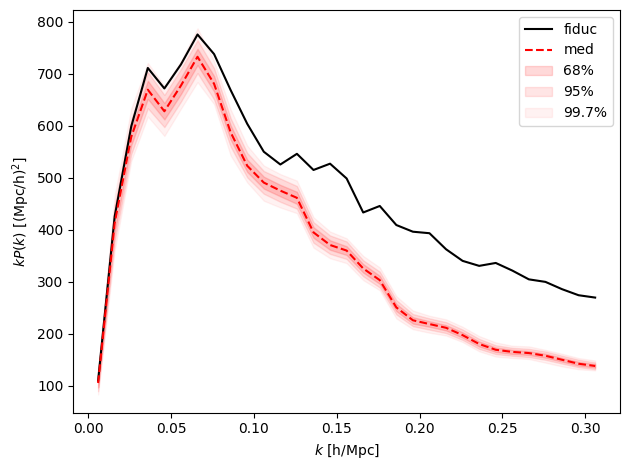

In [10]:
plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)
plotfill_fn = lambda pklow, pkup, *args, **kwargs: plt.fill_between(pklow[0], pklow[0]*pklow[1], pklow[0]*pkup[1], *args, **kwargs)

plot_fn(pk_fiduc, 'k', label='fiduc')
plot_fn(pk_5000, 'r--', label='med')
plotfill_fn(pk_1600, pk_8400, alpha=0.15, color='red', label='68%')
plotfill_fn(pk_0250, pk_9750, alpha=0.10, color='red', label='95%')
plotfill_fn(pk_0015, pk_9985, alpha=0.05, color='red', label='99.7%')
plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P(k)$ [(Mpc/h)$^2$]")
plt.legend()
plt.tight_layout()
# plt.savefig('post_pk.svg', dpi=200, bbox_inches='tight')
plt.show()

### Mass matrix

In [132]:
# Load mass matrix
import pickle
with open(save_path+f"_laststate16.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

0.0036300123 {('Omega_c_', 'b1_', 'b2_', 'bnl_', 'bs_', 'init_mesh_', 'sigma8_'): Array([6.1043068e-03, 1.6954450e-03, 7.9886860e-04, ..., 8.5615098e-01,
       6.2965083e-01, 3.9922595e-03], dtype=float32)}


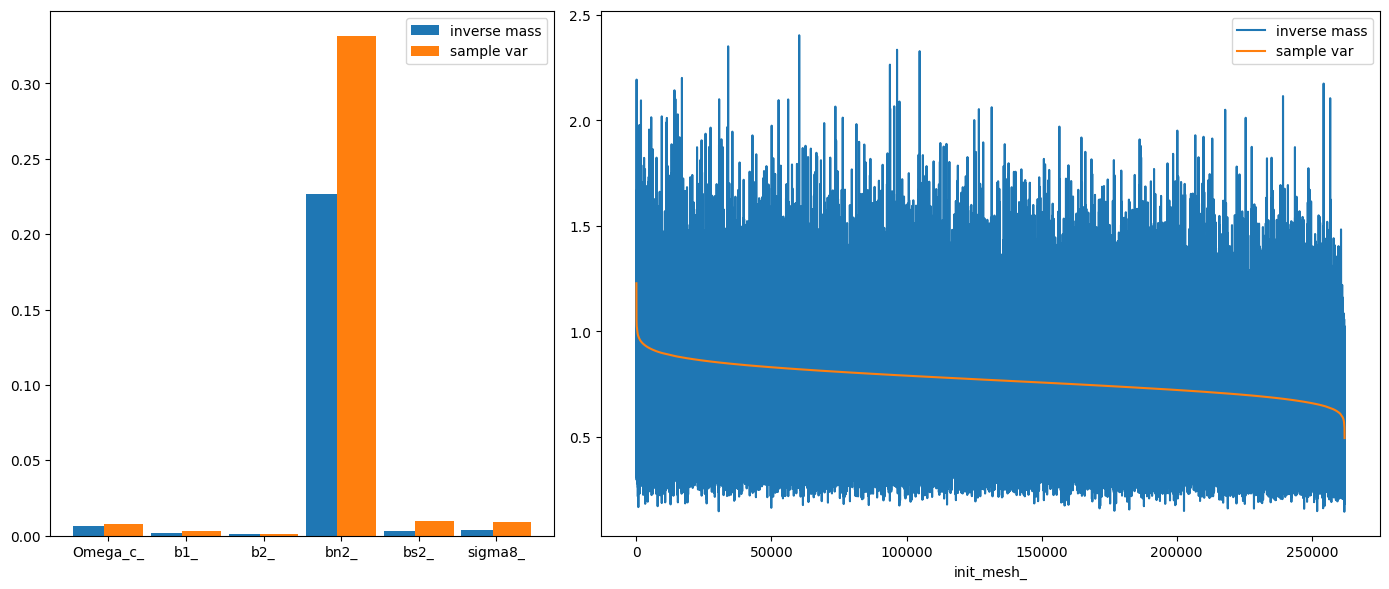

In [143]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    if var_name == 'bnl_':
        var_name = 'bn2_'
    if var_name == 'bs_':
        var_name = 'bs2_'
    var_variance = post_samples_[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,6))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_")
plt.legend(), plt.tight_layout()
plt.savefig(save_path+"_invMvar.svg");

In [ ]:
# # Save posterior variance as inverse mass matrix format
# post_variance = []
# for var_name in var_names:
#     if var_name == 'init_mesh_base':
#         var_name = 'init_mesh'
#         post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
#     else:
#         post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
#         post_variance = np.concatenate((post_variance, ))
# variance_as_invM = {var_names: post_variance}
# print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

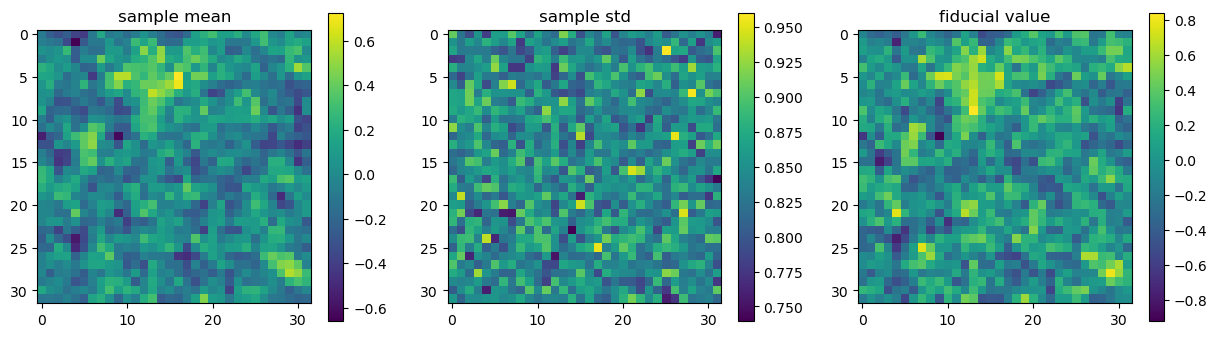

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();